# Sumário

[Funções de Ativação](#Funções-de-Ativação)

[Funções Auxiliares](#Funções-Auxiliares)

[Funções de Custo](#Funções-de-Custo)

[Inicialização de Pesos](#Inicialização-de-Pesos)

[Regularização](#Regularização)

[Learning Rate Decay](#Learning-Rate-Decay)

[Batch Normalization](#Batch-Normalization)

[Batch Generator](#Batch-Generator)

[Implementação](#Implementação)

[Testes da Implementação](#Testes-da-Implementação)

- [Exemplos do Notebook da Intuição](#Exemplos-do-Notebook-da-Intuição)

- [Regressão](#Regressão)
    - [Regressão Linear Simples](#Regressão-Linear-Simples---Exemplo-do-Perceptron)
    - [Regressão Linear Multivariada](#Regressão-Linear-Multivariada---Exerc%C3%ADcio-de-Regressão-do-Perceptron)
    - [Regressão Quadrática](#Regressão-Quadrática)
    - [Regressão Cúbica](#Regressão-Cúbica)
    - [Regressão Logarítimica](#Regressão-Logar%C3%ADtimica)
    - [Regressão Exponencial](#Regressão-Exponencial)

- [Classificação Binária](#Classificação-Binária)
    - [Porta AND/OR](#Porta-AND/OR)
    - [Porta XOR](#Porta-XOR)
    - [2 Clusters](#2-Clusters)
    - [4 Clusters](#4-Clusters)
    - [Círculos](#C%C3%ADrculos)
    - [Moons](#Moons)
    - [Espiral](#Espiral)
    
- [Classificação Multiclasse](#Classificação-Multiclasse)
    - [3 Clusters Multiclasse](#3-Clusters-Multiclasse)
    - [4 Clusters Multiclasse](#4-Clusters-Multiclasse)
    - [Espiral - 5 Classes](#Espiral---5-Classes)
    - [Make Classification - 4 Classes](#Make-Classification---4-Classes)
    - [Iris Dataset](#Iris-Dataset)

[Referências](#Referências)

# Imports and Configurações

In [1]:
import numpy as np
import _pickle as pkl
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.datasets import make_blobs, make_circles, make_moons, make_classification
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from utils import plot
from utils.samples_generator import make_spiral, make_square, make_cubic, make_exp, make_log10

%matplotlib inline

# Funções de Ativação

In [2]:
def linear(x, derivative=False):
    return np.ones_like(x) if derivative else x

def sigmoid(x, derivative=False):
    if derivative:
        y = sigmoid(x)
        return y*(1 - y)
    return 1.0/(1.0 + np.exp(-x))

def tanh(x, derivative=False):
    if derivative:
        y = tanh(x)
        return 1 - y**2
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0, 1)
    return np.maximum(0, x)

def leaky_relu(x, derivative=False):
    alpha = 0.1
    if derivative:
        return np.where(x <= 0, alpha, 1)
    return np.where(x <= 0, alpha*x, x)

def elu(x, derivative=False):
    alpha = 1.0
    if derivative:
        y = elu(x)
        return np.where(x <= 0, y + alpha, 1)
    return np.where(x <= 0, alpha*(np.exp(x) - 1), x)

# Funções Auxiliares

In [3]:
def softmax(x, y_oh=None, derivative=False):
    if derivative:
        y_pred = softmax(x)
        k = np.nonzero(y_pred * y_oh)
        pk = y_pred[k]
        y_pred[k] = pk * (1.0 - pk)
        return y_pred
    exp = np.exp(x)
    return exp / np.sum(exp, axis=1, keepdims=True)

# Funções de Custo

###### Para Regressão

In [4]:
def mae(y, y_pred, derivative=True):
    if derivative:
        return np.where(y_pred > y, 1, -1) / y.shape[0]
    return np.mean(np.abs(y - y_pred))

def mse(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred) / y.shape[0]
    return 0.5 * np.mean((y - y_pred) ** 2)

###### Para Classificação Binária

In [5]:
def binary_cross_entropy(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])
    return - np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

def sigmoid_cross_entropy(y, y_pred, derivative=True):
    y_sigmoid = sigmoid(y_pred)
    if derivative:
        return -(y - y_sigmoid) / y.shape[0]
    return - np.mean(y * np.log(y_sigmoid) + (1 - y) * np.log(1 - y_sigmoid))

###### Para Classificação Multiclasse

In [6]:
def neg_log_likelihood(y_oh, y_pred, derivative=False):
    k = np.nonzero(y_pred * y_oh)
    pk = y_pred[k]
    if derivative:
        y_pred[k] = (-1.0 / pk)
        return y_pred
    return np.mean(-np.log(pk))

def softmax_neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_softmax = softmax(y_pred)
    if derivative:
        return -(y_oh - y_softmax) / y_oh.shape[0]    
    return neg_log_likelihood(y_oh, y_softmax)

# Inicialização de Pesos

In [7]:
def zeros(rows, cols): #neuronios da camada atual, neuronios da camada anterior
    return np.zeros((rows, cols))

def ones(rows, cols):
    return np.ones((rows, cols))

def random_normal(rows, cols):
    return np.random.randn(rows, cols)

def random_uniform(rows, cols):
    return np.random.rand(rows, cols)

def glorot_normal(rows, cols):
    # distribuição com média zero e desvio padrao raiz de 2/in+out
    #desvio padrao = sigma
    std_dev = np.sqrt(2.0 / rows + cols)
    return std_dev * np.random.randn(rows, cols)

def glorot_uniform(rows, cols):
    # aqui, a distribuição vai de -sigma a +sigma
    limit = np.sqrt(6.0 / (rows + cols)) #sigma/desvio padrao
    return 2 * limit * np.random.randn(rows, cols) - limit

# Regularização

In [8]:
def l1_regularization(weights, derivative=False):
    if derivative:
        weights = [np.where(w < 0, -1, w) for w in weights]
        return np.array([np.where(w > 0, 1, w) for w in weights])
    return np.sum([np.sum(np.abs(w)) for w in weights])

def l2_regularization(weights, derivative=False):
    if derivative:
        return weights
    return 0.5 * np.sum(weights ** 2)

# Batch Generator

In [9]:
def batch_sequential(x, y, batch_size=None):
    batch_size = x.shape[0] if batch_size is None else batch_size
    n_batches = x.shape[0] // batch_size # divisao inteira arredondada pra baixo
    
    for batch in range(n_batches):
        offset = batch_size * batch # inicio do batch
        x_batch, y_batch = x[offset: offset + batch_size], y[offset: offset + batch_size]
        yield(x_batch, y_batch) # parecido com return, mas pausa a função até ser chamada novamente
               
def batch_shuffle(x, y, batch_size=None):
    shuffle_index = np.random.permutation(range(x.shape[0]))
    return batch_sequential(x[shuffle_index], y[shuffle_index], batch_size)

# Learning Rate Decay

In [10]:
def none_decay(learning_rate, epoch, decay_rate, decay_steps=1):
    return learning_rate

def time_based_decay(learning_rate, epoch, decay_rate, decay_steps=1):
    return 1.0 / (1.0 + decay_rate * epoch)

def exponential_decay(learning_rate, epoch, decay_rate, decay_steps=1):
    return learning_rate * decay_rate ** epoch

def staircase_decay(learning_rate, epoch, decay_rate, decay_steps=1):
    return learning_rate * decay_rate ** (epoch // decay_steps)

# Batch Normalization 

In [37]:
def batchnorm_forward(layer, x, is_training=True):
    mu = np.mean(x, axis=0) if is_training else layer._pop_mean
    var = np.var(x, axis=0) if is_training else layer._pop_var
    x_norm = (x - mu) / np.sqrt(var + 1e-8)
    out = layer.gamma * x_norm + layer.beta
    
    if is_training:
        layer._pop_mean = layer.bn_decay * layer._pop_mean + (1.0 - layer.bn_decay) * mu
        layer._pop_var = layer.bn_decay * layer._pop_var + (1.0 - layer.bn_decay) * var
        layer._bn_cache = (x, x_norm, mu, var)
    
    return out
    
def batchnorm_backward(layer, dactivation):
    x, x_norm, mu, var = layer._bn_cache
    
    m = layer._activ_inp.shape[0] #n de amostrar do batch
    x_mu = x - mu
    std_inv = 1.0 / np.sqrt(var + 1e-8)
    
    dx_norm = dactivation * layer.gamma
    dvar = np.sum(dx_norm * x_mu, axis=0) * -0.5 * (std_inv ** 3)
    dmu = np.mean(dx_norm * -std_inv, axis=0) + dvar * np.mean(-2.0 * x_mu, axis=0)
    
    dx = (dx_norm * std_inv) + (dvar * 2.0 * x_mu / m) + (dmu / m)
    layer._dgamma = np.sum(dactivation * x_norm, axis=0)
    layer._dbeta = np.sum(dactivation, axis=0)
    
    return dx

# Implementação 

In [39]:
# camada
class Layer():
    def __init__(self, input_dim, output_dim, weights_initializer=random_normal,
                 biases_initializer=ones, activation=linear, dropout_prob=0.0,
                 reg_func=l2_regularization, reg_strength=0.0, batch_norm=False, bn_decay=0.9):
        self.input = None
        
        # antes de definir os métodos de inicializacao
        #self.weights = np.random.randn(output_dim, input_dim) # linhas x colunas (inicalizando de forma aleatória)
        #self.biases = np.random.randn(1, output_dim) #output_dim = quantidade de neuronios da camada
        
        #aqui, ja definidos os métodos de incializacao
        self.weights = weights_initializer(output_dim, input_dim)
        self.biases = biases_initializer(1, output_dim) 
        
        self.dropout_prob = dropout_prob
        
        # salvando na camada os parametros de regularização
        self.reg_func = reg_func
        self.reg_strength = reg_strength
        
        
        self.activation = activation
        
        # entrada e saída da função de ativação, usada nas derivadas
        self._activ_inp, self._activ_out = None, None
        
        # vars para armazenar a derivada em relacao aos pesos e em relacao aos bias
        self._dweights, self._dbiases, self._prev_dweights = None, None, 0.0
        # A self._pref_dweights tem o objetivo de guardar o gradiente anterior para calculo do momentum
        
        # armazenando info para saber quais neuronios foram dropados e mantidos
        self._dropout_mask = None
        
        # batch normalization
        self.batch_norm = batch_norm
        self.bn_decay = bn_decay
        self.gamma, self.beta = ones(1, output_dim), zeros(1, output_dim) 
        self._dgamma, self._dbeta = None, None
        self._pop_mean, self._pop_var = zeros(1, output_dim), zeros(1, output_dim)
        self._bn_cache = None

# rede
class NeuralNetwork():
    def __init__(self, cost_func=mse,
                 lr_decay_method=none_decay, lr_decay_rate=0.0, lr_decay_steps=1,
                 learning_rate=1e-3, momentum=0.0, patience=np.inf):
        self.layers = [] # array de camas com objetos da classe Layer
        self.cost_func = cost_func
        self.learning_rate = self.lr_initial = learning_rate # guardando a lr inicial para usar no metodo decay
        self.lr_decay_method = lr_decay_method
        self.lr_decay_rate = lr_decay_rate
        self.lr_decay_steps = lr_decay_steps
        self.momentum = momentum
        self.patience, self.waiting = patience, 0
        self._best_model, self._best_loss = self.layers, np.inf
    
    def fit(self, x_train, y_train, x_val = None, y_val = None, epochs=100, verbose=10, batch_gen=batch_sequential, batch_size=None): #verbose = mostrar a função de custo        
        # atribuindo x_train e y_train como dfs de val caso nao sejam passados quando utilizar early stopping
        x_val, y_val = (x_train, y_train) if (x_val is None or y_val is None) else (x_val, y_val)
        
        for epoch in range(epochs + 1):
        # implementando o decay
            self.learning_rate = self.lr_decay_method(self.lr_initial, epoch, self.lr_decay_rate, self.lr_decay_steps)

            # sem batch
            #y_pred = self.__feedforward(x_train)
            #self.__backprop(y_train, y_pred)
            
            # com batch
            for x_batch, y_batch in batch_gen(x_train, y_train):                
                y_pred = self.__feedforward(x_batch)
                self.__backprop(y_batch, y_pred)            
            
            # implementando early stopping
            loss_val = self.cost_func(y_val, self.predict(x_val)) #y_pred do banco de val
            if loss_val < self._best_loss:
                self._best_model, self._best_loss = self.layers, loss_val
            else:
                self.waiting += 1
                #print("Not improving! [{}] current: {} best: {}".format(self.waiting, loss_val, self._best_loss))
                if self.waiting >= self.patience:
                    self.layers = self._best_model
                    #print("Early stopping at epoch: ", epoch)
                    return
            
            
            if epoch % verbose == 0:
                loss_train = self.cost_func(y_train, self.predict(x_train))
                # adicionando regularização
                # calculando o lambda vezes o somatório da regularização
                loss_reg = (1.0 / y_train.shape[0]) * np.sum([layer.reg_strength * layer.reg_func(layer.weights) for layer in self.layers])
                print("epoch: {0:=4}/{1}. loss_train: {2:.8f} + {3:.8f} = {4:.8f}. loss_val = {5:8f}".format(epoch, epochs, loss_train, loss_reg, loss_train + loss_reg, loss_val))
    
    def predict(self, x):
        return self.__feedforward(x, is_training=False) #passando as amostrar no feed forward
    
    def __feedforward(self, x, is_training=True): # deixando "nao acessivel" com o "__"
        self.layers[0].input = x # entrada da primeira camada, os dados
        
        # loop para acessar a camada atual e a próxima, para calcular a função de ativação 
        for current_layer, next_layer in zip(self.layers, self.layers[1:] + [Layer(0, 0)]): 
            # adicionando um layer com a camada vazia para os dois arrays terem o msm tamanho e a
            #current_layer acessar a ultima camada
            y = np.dot(current_layer.input, current_layer.weights.T) + current_layer.biases
            
            # batch normalization
            y = batchnorm_forward(current_layer, y, is_training) if current_layer.batch_norm else y
            
            # implementando dropout e reescalando ativações
            current_layer._dropout_mask = np.random.binomial(1, 1.0 - current_layer.dropout_prob, y.shape) / (1.0 - current_layer.dropout_prob)
            
            current_layer._activ_inp = y
            current_layer._activ_out = current_layer.activation(y) * (current_layer._dropout_mask if is_training else 1.0)
            next_layer.input = current_layer._activ_out
        return self.layers[-1]._activ_out
    
    
    def __backprop(self, y, y_pred):
        # derivada da função de custo
        last_delta = self.cost_func(y, y_pred, derivative=True)
        
        # derivada em relacao as camadas
        for layer in reversed(self.layers):
            
            # derivada da função de ativação
            dactivation = layer.activation(layer._activ_inp, derivative=True) * last_delta * layer._dropout_mask # calculando para os nao dropados caso dropout_prob >0% 
            
            # batch normalization
            dactivation = batchnorm_backward(layer, dactivation) if layer.batch_norm else dactivation
            
            # atualizando o last_delta
            last_delta = np.dot(dactivation, layer.weights)
            
            # derivada em relacao aos pesos e bias
            layer._dweights = np.dot(dactivation.T, layer.input)
            layer._dbiases = 1.0 * dactivation.sum(axis=0, keepdims=True)
            
        # atualizando pesos e bias
        for layer in reversed(self.layers):
            layer._dweights = layer._dweights + (1.0 + y.shape[0]) * layer.reg_strength * layer.reg_func(layer.weights, derivative=True) # adicionando a regularização antes da atualização dos pesos. Derivada em relação aos pesos anteriores                                                  
            layer._prev_dweights = - self.learning_rate * layer._dweights + self.momentum * layer._prev_dweights# calculando o momentum
            # antes, sem momemtum:
            #layer.weights = layer.weights - self.learning_rate * layer._dweights
            # com momentum:
            layer.weights = layer.weights + layer._prev_dweights
            layer.biases = layer.biases - self.learning_rate * layer._dbiases  
            
            # atualizacao do gamma e beta quando batch_norm
            if layer.batch_norm:
                layer.gamma = layer.gamma - self.learning_rate * layer._dgamma
                layer.beta = layer.beta - self.learning_rate * layer._dbeta

In [24]:
# testando early stopping
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

x, y = make_regression(n_samples=100, n_features=1, n_informative=2, noise=10.0, random_state=42)
x, y = x.reshape(-1, 1), y.reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-1, patience=10)
nn.layers.append(Layer(input_dim = x.shape[1], output_dim = y.shape[1], activation=linear))
nn.fit(x_train, y_train, x_val=x_test, y_val=y_test, epochs=1000, verbose=50)

epoch:    0/1000. loss_train: 675.19318451 + 0.00000000 = 675.19318451. loss_val = 710.699016
epoch:   50/1000. loss_train: 35.44031556 + 0.00000000 = 35.44031556. loss_val = 53.310935
epoch:  100/1000. loss_train: 35.23224313 + 0.00000000 = 35.23224313. loss_val = 51.770843
epoch:  150/1000. loss_train: 35.23214680 + 0.00000000 = 35.23214680. loss_val = 51.737272
epoch:  200/1000. loss_train: 35.23214675 + 0.00000000 = 35.23214675. loss_val = 51.736530
epoch:  250/1000. loss_train: 35.23214675 + 0.00000000 = 35.23214675. loss_val = 51.736514
epoch:  300/1000. loss_train: 35.23214675 + 0.00000000 = 35.23214675. loss_val = 51.736513
epoch:  350/1000. loss_train: 35.23214675 + 0.00000000 = 35.23214675. loss_val = 51.736513
epoch:  400/1000. loss_train: 35.23214675 + 0.00000000 = 35.23214675. loss_val = 51.736513
epoch:  450/1000. loss_train: 35.23214675 + 0.00000000 = 35.23214675. loss_val = 51.736513


## Exemplos do Notebook da Intuição

### Exemplo 1

Neste exemplo, a rede possui:
- 2 camadas
- função de ativação sigmoid
- learning rate de 0.5
- 1 epoch

In [79]:
# entradas
x = np.array([[0.05, 0.10]])
y = np.array([[0.01, 0.99]])

# pesos e bias
w1 = np.array([[0.15, 0.20], [0.25, 0.30]])
b1 = np.array([[0.35]]) 
w2 = np.array([[0.40, 0.45], [0.50, 0.55]])
b2 = np.array([[0.60]])

# defninindo dimensoes
input_dim, output_dim = x.shape[1], y.shape[1] # N colunas

# definindo a rede
nn = NeuralNetwork(cost_func=mse, learning_rate = 0.5)

# adicionando camadas
# a dimensao da saída é 2 porque é igual ao numero de neuronios
nn.layers.append(Layer(input_dim=input_dim, output_dim=2, activation=sigmoid))

#input_dim = 2 porque a entrada da próxima é igual a saída da anterior
nn.layers.append(Layer(input_dim=2, output_dim=output_dim, activation=sigmoid))

# atribuindo pesos e bias
nn.layers[0].weights = w1 # primeira camada
nn.layers[0].biases = b1
nn.layers[1].weights = w2 # segunda camada
nn.layers[1].biases = b2

# fitando a rede
nn.fit(x, y, epochs=0, verbose=1)

# visualizando pesos da camada
for layer in nn.layers:
    print(layer.weights)

epoch:    0/0. loss_train: 0.14023572
[[0.14978072 0.19956143]
 [0.24975114 0.29950229]]
[[0.35891648 0.40866619]
 [0.51130127 0.56137012]]


### Exemplo 2

Neste segundo exemplo, a rede possui:
- 3 camadas;
- Cada uma com a seguinte função de ativação: relu, sigmoid, linear;
- Como função de custo soft_max_neg_log_likelihood;
- Learning rate de 0.01
- 300 epochs

In [80]:
x = np.array([[0.1, 0.2, 0.7]])
y = np.array([[1, 0, 0]])

# defninindo dimensoes
D_in, D_out = x.shape[1], y.shape[1]

w1 = np.array([[0.1, 0.2, 0.3], [0.3, 0.2, 0.7], [0.4, 0.3, 0.9]])
b1 = np.ones((1,3))
w2 = np.array([[0.2, 0.3, 0.5], [0.3, 0.5, 0.7], [0.6, 0.4, 0.8]])
b2 = np.ones((1,3))
w3 = np.array([[0.1, 0.4, 0.8], [0.3, 0.7, 0.2], [0.5, 0.2, 0.9]])
b3 = np.ones((1,3))

# definindo a rede
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate = 0.01)

# adicionando camadas
nn.layers.append(Layer(input_dim=D_in, output_dim=3, activation=relu))
nn.layers.append(Layer(input_dim=3, output_dim=3, activation=sigmoid)) 
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=linear)) 

# atribuindo pesos e bias
for i, w, b in zip(range(3), [w1, w2, w3], [b1, b2, b3]):
    nn.layers[i].weights = w
    nn.layers[i].biases = b

# fitando a rede
nn.fit(x, y, epochs=300, verbose=30)

# visualizando pesos da camada
for layer in nn.layers:
    print(layer.weights)

epoch:    0/300. loss_train: 1.14054966
epoch:   30/300. loss_train: 0.59630022
epoch:   60/300. loss_train: 0.36031189
epoch:   90/300. loss_train: 0.24668884
epoch:  120/300. loss_train: 0.18386202
epoch:  150/300. loss_train: 0.14510157
epoch:  180/300. loss_train: 0.11918285
epoch:  210/300. loss_train: 0.10078511
epoch:  240/300. loss_train: 0.08712037
epoch:  270/300. loss_train: 0.07660623
epoch:  300/300. loss_train: 0.06828531
[[0.10083595 0.2016719  0.30585165]
 [0.30086971 0.20173942 0.70608796]
 [0.40145052 0.30290104 0.91015363]]
[[0.20544723 0.30673159 0.50749567]
 [0.30994562 0.5123005  0.71366784]
 [0.61065514 0.41317913 0.81464085]]
[[ 0.66465527  0.98758148  1.39393956]
 [ 0.05020341  0.44006253 -0.06274803]
 [ 0.18514132 -0.12764401  0.56880846]]


## Gradient Checking

## Regressão

### Regressão Linear Simples - Exemplo do Perceptron

Exemplo com:
- 1 camada
- 1 neurônio

(100, 2)
(100, 1) (100, 1)


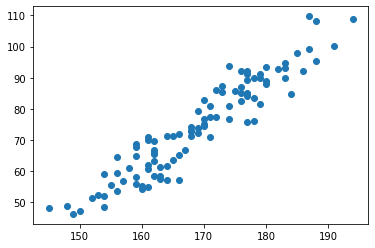

In [81]:
data = np.loadtxt('data/medidas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,0].reshape(-1,1), data[:,1].reshape(-1,1)
print(x.shape, y.shape)
plt.scatter(x, y)

-1.0 0.9999999999999991


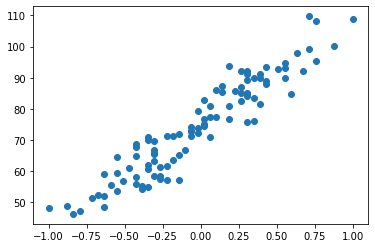

In [82]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(), x.max())
plt.scatter(x, y)

epoch:    0/1000. loss_train: 2783.15116870
epoch:  100/1000. loss_train: 444.05525746
epoch:  200/1000. loss_train: 112.18737464
epoch:  300/1000. loss_train: 54.83029576
epoch:  400/1000. loss_train: 38.25195034
epoch:  500/1000. loss_train: 29.90984187
epoch:  600/1000. loss_train: 24.58133536
epoch:  700/1000. loss_train: 20.97087500
epoch:  800/1000. loss_train: 18.49470102
epoch:  900/1000. loss_train: 16.79240710
epoch: 1000/1000. loss_train: 15.62158825
[[28.34903528]]
[[74.85875592]]


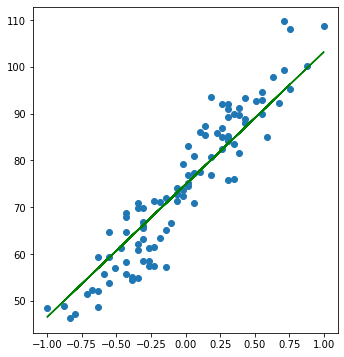

In [83]:
input_dim, output_dim = x.shape[1], y.shape[1]

# inicializando a rede
nn = NeuralNetwork(cost_func=mse, learning_rate=1e-2)
nn.layers.append(Layer(input_dim=input_dim, output_dim=output_dim, activation=linear))
nn.fit(x, y, epochs=1000, verbose=100)

print(nn.layers[0].weights)
print(nn.layers[0].biases)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Linear Multivariada - Exercício de Regressão do Perceptron

In [84]:
data = np.loadtxt('data/notas.csv', delimiter=',', skiprows=1)
print(data.shape)

x = data[:, :-1]
y = data[:, -1].reshape(-1,1)

x.shape, y.shape

(25, 4)


((25, 3), (25, 1))

In [85]:
x.shape, y.shape

((25, 3), (25, 1))

In [86]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1. -1. -1.] [1. 1. 1.]


In [87]:
input_dim, output_dim = x.shape[1], y.shape[1]

# incializando a rede
nn = NeuralNetwork(cost_func=mse, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=output_dim, activation=linear))

nn.fit(x, y, epochs=5000, verbose=500)

print(nn.layers[0].weights)
print(nn.layers[0].biases)

epoch:    0/5000. loss_train: 10252.17853792
epoch:  500/5000. loss_train: 3.51004417
epoch: 1000/5000. loss_train: 2.91924233
epoch: 1500/5000. loss_train: 2.87465635
epoch: 2000/5000. loss_train: 2.86963371
epoch: 2500/5000. loss_train: 2.86899826
epoch: 3000/5000. loss_train: 2.86891590
epoch: 3500/5000. loss_train: 2.86890518
epoch: 4000/5000. loss_train: 2.86890378
epoch: 4500/5000. loss_train: 2.86890360
epoch: 5000/5000. loss_train: 2.86890358
[[ 8.72095888 14.10518297 26.26731406]]
[[150.65173124]]


### Regressão Quadrática

(100, 1) (100, 1)


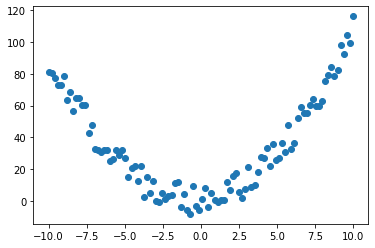

In [37]:
x, y = make_square(n_samples=100, x_min=-10, x_max=10, a=1, b=1, c=1, noise=10)

print(x.shape, y.shape)
plt.scatter(x, y)

In [38]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/5000. loss_train: 1872.36047425
epoch:  500/5000. loss_train: 17.46060483
epoch: 1000/5000. loss_train: 15.74310737
epoch: 1500/5000. loss_train: 15.39256031
epoch: 2000/5000. loss_train: 15.70979519
epoch: 2500/5000. loss_train: 15.52983584
epoch: 3000/5000. loss_train: 15.61689241
epoch: 3500/5000. loss_train: 14.92474420
epoch: 4000/5000. loss_train: 14.76401819
epoch: 4500/5000. loss_train: 14.67582072
epoch: 5000/5000. loss_train: 14.56490503
[[-0.04251912]
 [-0.47638307]
 [-0.50208493]
 [ 3.22966299]
 [ 1.43434504]
 [-4.07262937]
 [-0.44129456]
 [ 0.42903797]
 [ 0.21819956]
 [-3.04823091]
 [-2.07349631]
 [ 0.56643411]
 [-0.4047801 ]
 [-1.20277212]
 [ 0.33788847]
 [-0.82317279]
 [-0.48612576]
 [ 1.38097218]
 [ 0.70410828]
 [ 0.70355097]]
[[-0.4160032  -0.83601407 -0.13754572 -0.50482009 -1.61197921 -0.77482138
  -0.48591783 -0.43263612 -0.45578341 -1.77630657 -1.22496051  0.4743808
  -0.8964734  -1.20704074 -0.72286488  1.3231022  -0.80210733 -0.20953064
   0.50589748 

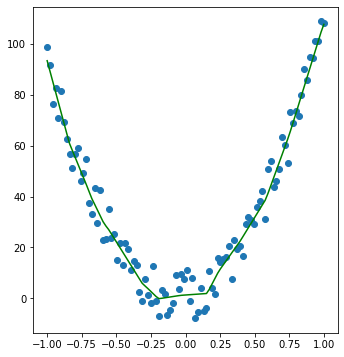

In [90]:
input_dim, output_dim = x.shape[1], y.shape[1]

# incializando a rede
nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=input_dim, output_dim=20, activation=relu))
nn.layers.append(Layer(input_dim=20, output_dim=20, activation=relu))
nn.layers.append(Layer(input_dim=20, output_dim=20, activation=relu))
nn.layers.append(Layer(input_dim=20, output_dim=output_dim, activation=linear))

nn.fit(x, y, epochs=5000, verbose=500)

print(nn.layers[0].weights)
print(nn.layers[0].biases)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

epoch:    0/5000. loss_train: 688.10339691
epoch:  500/5000. loss_train: 16.33720096
epoch: 1000/5000. loss_train: 15.80253192
epoch: 1500/5000. loss_train: 15.43038339
epoch: 2000/5000. loss_train: 15.15728707
epoch: 2500/5000. loss_train: 14.98911147
epoch: 3000/5000. loss_train: 14.80734923
epoch: 3500/5000. loss_train: 14.68203051
epoch: 4000/5000. loss_train: 14.59173520
epoch: 4500/5000. loss_train: 14.49158105
epoch: 5000/5000. loss_train: 14.16465174
[[-0.94369125]
 [ 1.22970675]
 [ 0.12081971]
 [ 0.05480525]
 [ 2.56812577]
 [-0.38204054]
 [-2.22588016]
 [-0.6996865 ]
 [ 0.39232317]
 [ 0.94818088]
 [ 1.0794899 ]
 [-0.9127881 ]
 [ 0.94383739]
 [-1.14287436]
 [-1.2979515 ]
 [-2.58867217]
 [-0.92527973]
 [-0.58554566]
 [-0.35451909]
 [-1.15960978]]
[[1.28322192 1.10541566 1.00753898 0.62717079 1.11545124 0.80669899
  0.94307394 1.07043164 1.0135288  0.90300044 0.97047766 0.91291902
  0.75264312 1.07367327 1.29866815 0.81058648 0.92652957 0.67959992
  1.00440284 0.92523217]]


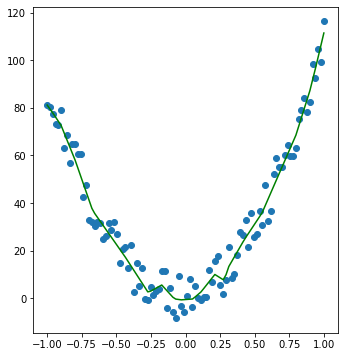

In [63]:
# utilizanod o momentum
input_dim, output_dim = x.shape[1], y.shape[1]

# incializando a rede
nn = NeuralNetwork(cost_func=mse, learning_rate=1e-4, momentum=0.9)
nn.layers.append(Layer(input_dim=input_dim, output_dim=20, activation=relu))
nn.layers.append(Layer(input_dim=20, output_dim=20, activation=relu))
nn.layers.append(Layer(input_dim=20, output_dim=20, activation=relu))
nn.layers.append(Layer(input_dim=20, output_dim=output_dim, activation=linear))


nn.fit(x, y, epochs=5000, verbose=500)

print(nn.layers[0].weights)
print(nn.layers[0].biases)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

epoch:    0/5000. loss_train: 872.07072002
epoch:  500/5000. loss_train: 24.86880415
epoch: 1000/5000. loss_train: 22.31146016
epoch: 1500/5000. loss_train: 22.00031316
epoch: 2000/5000. loss_train: 21.29596188
epoch: 2500/5000. loss_train: 21.14353930
epoch: 3000/5000. loss_train: 21.03543055
epoch: 3500/5000. loss_train: 20.99389167
epoch: 4000/5000. loss_train: 20.73232926
epoch: 4500/5000. loss_train: 20.07500174
epoch: 5000/5000. loss_train: 19.77895322
[[-1.12069158]
 [ 3.81593618]
 [ 1.38707864]
 [-3.12633803]]
[[ 1.12071374 -1.46260349  1.38687251  0.29439639]]


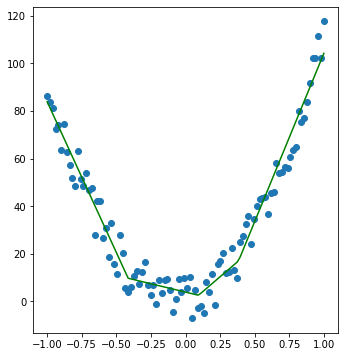

In [145]:
# utilizando os métodos de inicializacao de pesos e bias

input_dim, output_dim = x.shape[1], y.shape[1]

# incializando a rede
nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=input_dim, output_dim=4, activation=relu, weights_initializer=glorot_normal))
nn.layers.append(Layer(input_dim=4, output_dim=4, activation=relu,weights_initializer=glorot_normal, biases_initializer=glorot_normal))
nn.layers.append(Layer(input_dim=4, output_dim=4, activation=relu,weights_initializer=glorot_normal, biases_initializer=glorot_normal))
nn.layers.append(Layer(input_dim=4, output_dim=output_dim, activation=linear,weights_initializer=glorot_normal))

nn.fit(x, y, epochs=5000, verbose=500)

print(nn.layers[0].weights)
print(nn.layers[0].biases)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

epoch:    0/10000. loss_train: 4878.84350600
epoch: 1000/10000. loss_train: 28.40044464
epoch: 2000/10000. loss_train: 20.05682732
epoch: 3000/10000. loss_train: 19.61041882
epoch: 4000/10000. loss_train: 19.07610014
epoch: 5000/10000. loss_train: 19.16722474
epoch: 6000/10000. loss_train: 19.47398723
epoch: 7000/10000. loss_train: 19.30260209
epoch: 8000/10000. loss_train: 19.21855314
epoch: 9000/10000. loss_train: 18.95284394
epoch: 10000/10000. loss_train: 19.34208072
[[-0.27246472]
 [ 0.01917053]
 [-0.17390652]
 [-0.10388652]
 [-0.13558636]
 [-0.11491382]
 [ 0.00784305]
 [-0.24322617]
 [-1.59191352]
 [ 0.98434482]]
[[ 0.14561657  0.25469174  0.20138224  0.28265447  0.04288154  0.10695131
   0.16153741  0.86557503 -0.28744559 -0.30844424]]


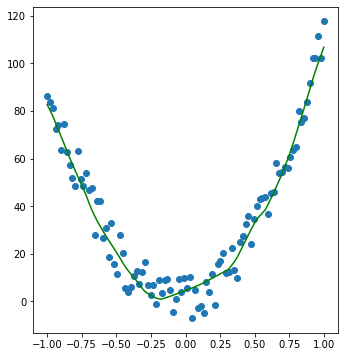

In [159]:
# com dropout
input_dim, output_dim = x.shape[1], y.shape[1]

# incializando a rede
nn = NeuralNetwork(cost_func=mse, learning_rate=1e-5)
nn.layers.append(Layer(input_dim=input_dim, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=100, activation=relu, dropout_prob=0.05))
nn.layers.append(Layer(input_dim=100, output_dim=100, activation=relu, dropout_prob=0.05))
nn.layers.append(Layer(input_dim=100, output_dim=output_dim, activation=linear))

nn.fit(x, y, epochs=10000, verbose=1000)

print(nn.layers[0].weights)
print(nn.layers[0].biases)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Cúbica

(100, 1) (100, 1)


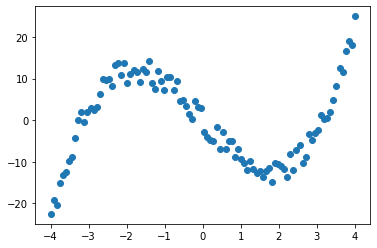

In [91]:
x, y = make_cubic(n_samples=100, x_min=-4, x_max=4, a=1, b=0, c=-10, d=0, noise=3)

print(x.shape, y.shape)
plt.scatter(x, y)

In [92]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/5000. loss_train: 42.77132792
epoch:  500/5000. loss_train: 5.94158510
epoch: 1000/5000. loss_train: 3.11098319
epoch: 1500/5000. loss_train: 2.33260357
epoch: 2000/5000. loss_train: 1.99031767
epoch: 2500/5000. loss_train: 1.81782183
epoch: 3000/5000. loss_train: 1.72349820
epoch: 3500/5000. loss_train: 1.66760953
epoch: 4000/5000. loss_train: 1.63152876
epoch: 4500/5000. loss_train: 1.60625521
epoch: 5000/5000. loss_train: 1.58709105


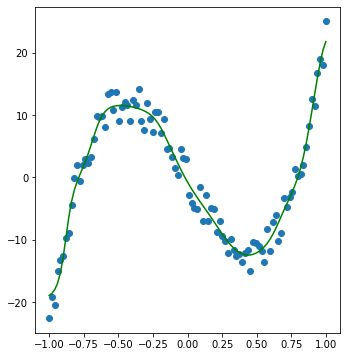

In [93]:
input_dim, output_dim = x.shape[1], y.shape[1]

# incializando a rede
nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=input_dim, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=output_dim, activation=linear))

nn.fit(x, y, epochs=5000, verbose=500)

# print(nn.layers[0].weights)
# print(nn.layers[0].biases)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Logarítimica

(100, 1) (100, 1)


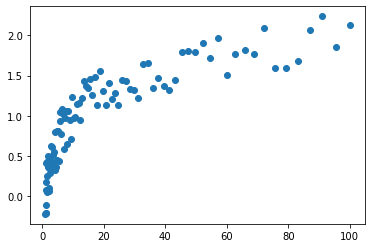

In [94]:
x, y = make_log10(n_samples=100, x_min=1, x_max=100, noise=0.3)

print(x.shape, y.shape)
plt.scatter(x, y)

In [95]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/10000. loss_train: 2.34005963
epoch:  500/10000. loss_train: 0.06001389
epoch: 1000/10000. loss_train: 0.05062186
epoch: 1500/10000. loss_train: 0.04491203
epoch: 2000/10000. loss_train: 0.04102456
epoch: 2500/10000. loss_train: 0.03823867
epoch: 3000/10000. loss_train: 0.03616618
epoch: 3500/10000. loss_train: 0.03457813
epoch: 4000/10000. loss_train: 0.03333042
epoch: 4500/10000. loss_train: 0.03232796
epoch: 5000/10000. loss_train: 0.03150585
epoch: 5500/10000. loss_train: 0.03081868
epoch: 6000/10000. loss_train: 0.03023407
epoch: 6500/10000. loss_train: 0.02972855
epoch: 7000/10000. loss_train: 0.02928487
epoch: 7500/10000. loss_train: 0.02889019
epoch: 8000/10000. loss_train: 0.02853483
epoch: 8500/10000. loss_train: 0.02821139
epoch: 9000/10000. loss_train: 0.02791416
epoch: 9500/10000. loss_train: 0.02763869
epoch: 10000/10000. loss_train: 0.02738147


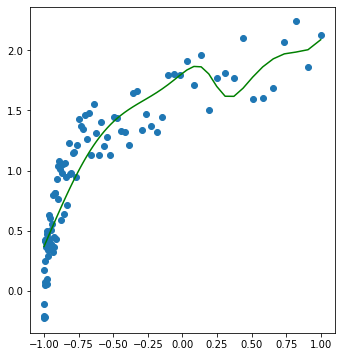

In [96]:
input_dim, output_dim = x.shape[1], y.shape[1]

# incializando a rede
nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=input_dim, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=output_dim, activation=linear))

nn.fit(x, y, epochs=10000, verbose=500)

# print(nn.layers[0].weights)
# print(nn.layers[0].biases)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Exponencial

(100, 1) (100, 1)


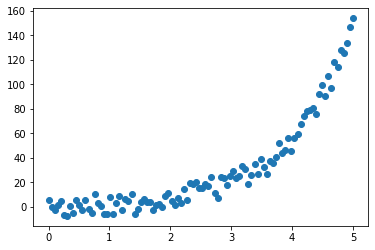

In [97]:
x, y = make_exp(n_samples=100, x_min=0, x_max=5, noise=10)

print(x.shape, y.shape)
plt.scatter(x, y)

In [98]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/5000. loss_train: 1251.20498005
epoch:  500/5000. loss_train: 81.59904330
epoch: 1000/5000. loss_train: 34.13583222
epoch: 1500/5000. loss_train: 22.71966183
epoch: 2000/5000. loss_train: 18.30508714
epoch: 2500/5000. loss_train: 16.23825249
epoch: 3000/5000. loss_train: 15.14400505
epoch: 3500/5000. loss_train: 14.49745611
epoch: 4000/5000. loss_train: 14.07923393
epoch: 4500/5000. loss_train: 13.78750673
epoch: 5000/5000. loss_train: 13.57050898


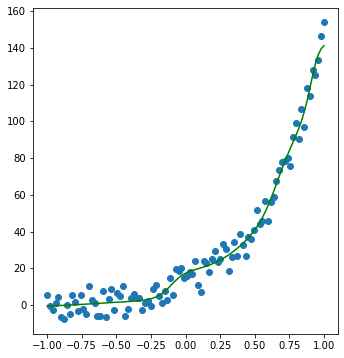

In [99]:
input_dim, output_dim = x.shape[1], y.shape[1]

# incializando a rede
nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=input_dim, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=output_dim, activation=linear))

nn.fit(x, y, epochs=5000, verbose=500)

# print(nn.layers[0].weights)
# print(nn.layers[0].biases)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

## Classificação Binária

### Porta AND/OR

(4, 2) (4, 1)


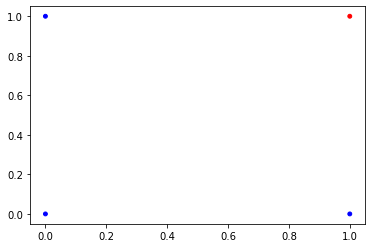

In [100]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 0, 0, 1]).reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/5000. loss_train: 1.48551015
epoch: 1000/5000. loss_train: 0.66904962
epoch: 2000/5000. loss_train: 0.46957673
epoch: 3000/5000. loss_train: 0.36563683
epoch: 4000/5000. loss_train: 0.30269475
epoch: 5000/5000. loss_train: 0.25989177
Predições:
[[0.05135327]
 [0.25218346]
 [0.22340043]
 [0.64183741]]
Acurácia: 100.00%


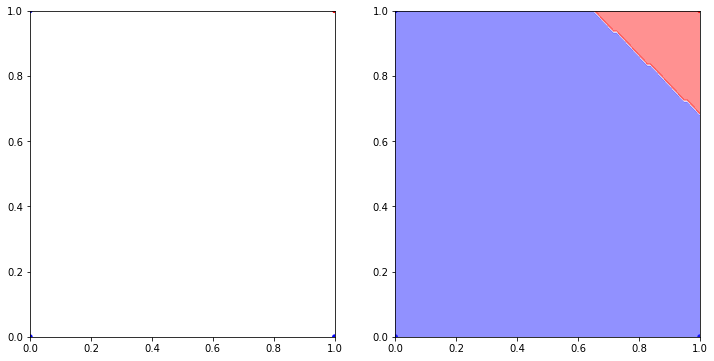

In [101]:
input_dim, output_dim = x.shape[1], y.shape[1]

# incializando a rede
nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-2)
#nn.layers.append(Layer(input_dim=input_dim, output_dim=20, activation=tanh))
#nn.layers.append(Layer(input_dim=20, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=input_dim, output_dim=output_dim, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=1000)

# print(nn.layers[0].weights)
# print(nn.layers[0].biases)

y_pred = nn.predict(x)
print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100 * accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Porta XOR

(4, 2) (4, 1)


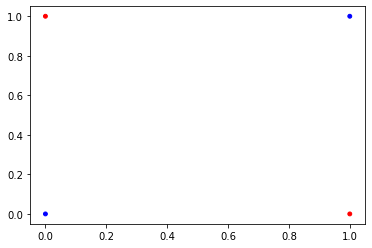

In [102]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0]).reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/5000. loss_train: 1.31437623
epoch: 1000/5000. loss_train: 0.28168789
epoch: 2000/5000. loss_train: 0.08182790
epoch: 3000/5000. loss_train: 0.03826896
epoch: 4000/5000. loss_train: 0.02330058
epoch: 5000/5000. loss_train: 0.01625148
Predições:
[[0.01275439]
 [0.98346167]
 [0.98378711]
 [0.01896499]]
Acurácia: 100.00%


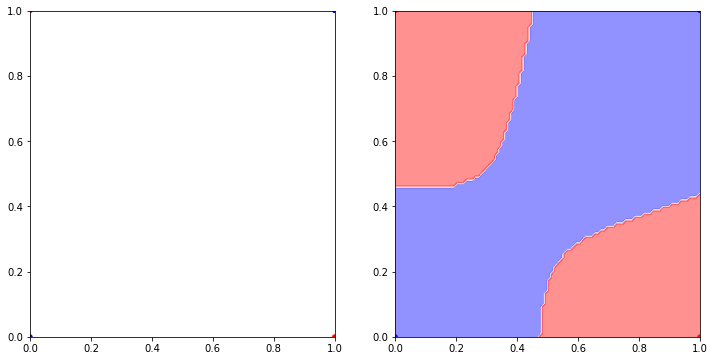

In [103]:
input_dim, output_dim = x.shape[1], y.shape[1]

# incializando a rede
nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=20, activation=sigmoid))
#nn.layers.append(Layer(input_dim=20, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=output_dim, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=1000)

# print(nn.layers[0].weights)
# print(nn.layers[0].biases)

y_pred = nn.predict(x)
print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### 2 Clusters

(100, 2) (100, 1)


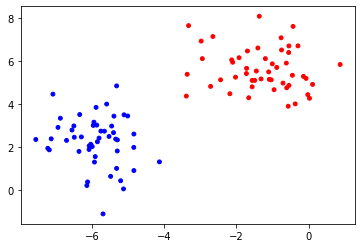

In [104]:
x, y = make_blobs(n_samples=100, n_features=2, centers=2, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/5000. loss_train: 1.26538894
epoch: 1000/5000. loss_train: 0.00630239
epoch: 2000/5000. loss_train: 0.00423513
epoch: 3000/5000. loss_train: 0.00335918
epoch: 4000/5000. loss_train: 0.00284436
epoch: 5000/5000. loss_train: 0.00249486
Acurácia: 100.00%


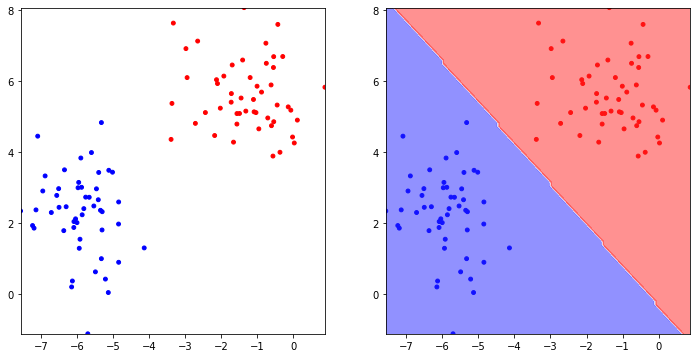

In [105]:
input_dim, output_dim = x.shape[1], y.shape[1]

# incializando a rede
nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=output_dim, activation=sigmoid))
#nn.layers.append(Layer(input_dim=20, output_dim=output_dim, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=1000)

# print(nn.layers[0].weights)
# print(nn.layers[0].biases)

y_pred = nn.predict(x)

threshold = 0 if nn.layers[-1].activation == linear else 0.5
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred >= threshold)))
plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=threshold, cmap='bwr')

### 4 Clusters

(500, 2) (500, 1)


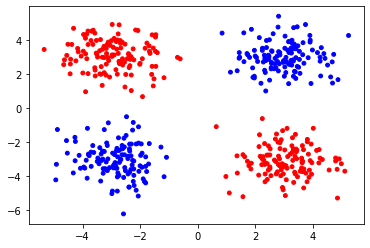

In [106]:
x, y = make_blobs(n_samples=500, n_features=2, cluster_std=0.9, centers=[(-3, -3), (3, 3), (-3, 3), (3, -3)], random_state=1234)
y = y.reshape(-1, 1)
y = np.where(y >= 2, 1, 0)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/5000. loss_train: 1.44380492
epoch: 1000/5000. loss_train: 0.05009936
epoch: 2000/5000. loss_train: 0.02299815
epoch: 3000/5000. loss_train: 0.01492863
epoch: 4000/5000. loss_train: 0.01110019
epoch: 5000/5000. loss_train: 0.00886597
Acurácia: 100.00%


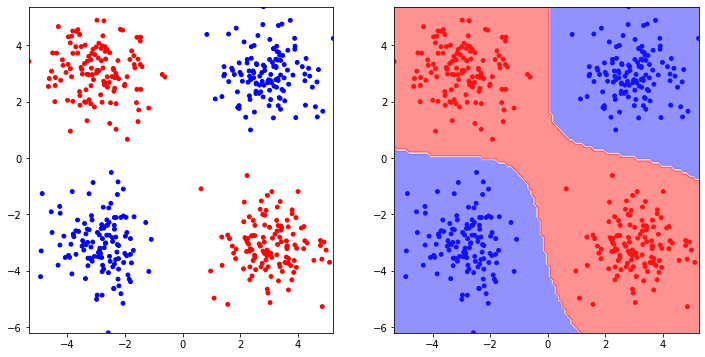

In [107]:
input_dim, output_dim = x.shape[1], y.shape[1]

# incializando a rede
nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=20, activation=sigmoid))
nn.layers.append(Layer(input_dim=20, output_dim=output_dim, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=1000)

# print(nn.layers[0].weights)
# print(nn.layers[0].biases)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Círculos

(500, 2) (500, 1)


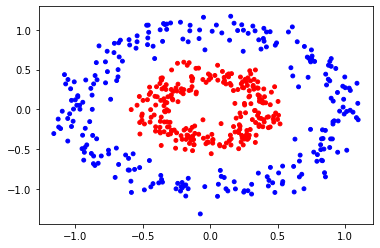

In [108]:
x, y = make_circles(n_samples=500, noise=0.1, factor=0.4, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/5000. loss_train: 0.82041669
epoch: 1000/5000. loss_train: 0.43965330
epoch: 2000/5000. loss_train: 0.22600444
epoch: 3000/5000. loss_train: 0.13049765
epoch: 4000/5000. loss_train: 0.08798240
epoch: 5000/5000. loss_train: 0.06549090
Acurácia: 100.00%


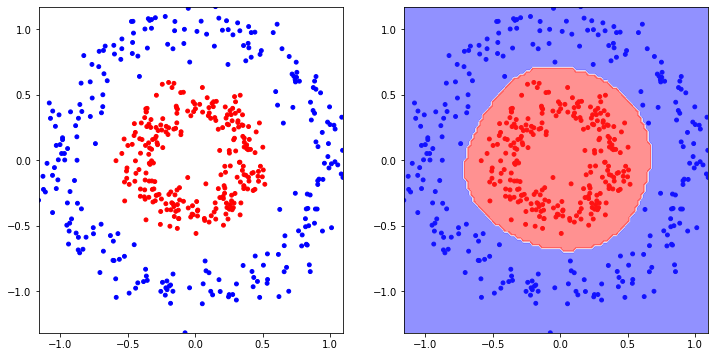

In [109]:
input_dim, output_dim = x.shape[1], y.shape[1]

# incializando a rede
nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=20, activation=sigmoid))
nn.layers.append(Layer(input_dim=20, output_dim=output_dim, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=1000)

# print(nn.layers[0].weights)
# print(nn.layers[0].biases)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Moons

(200, 2) (200, 1)


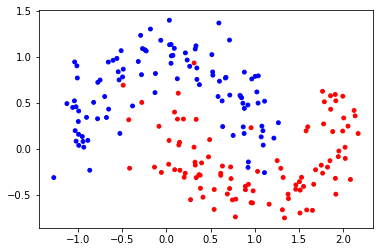

In [25]:
x, y = make_moons(200, noise=0.20)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/5000. loss_train: 0.93310598
epoch: 1000/5000. loss_train: 0.10613105
epoch: 2000/5000. loss_train: 0.08204355
epoch: 3000/5000. loss_train: 0.07342464
epoch: 4000/5000. loss_train: 0.06914943
epoch: 5000/5000. loss_train: 0.06656051
Acurácia: 98.00%


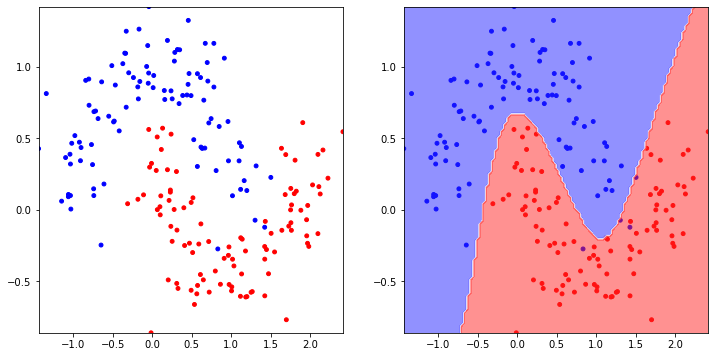

In [22]:
input_dim, output_dim = x.shape[1], y.shape[1]

# incializando a rede
nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=output_dim, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=1000)

# print(nn.layers[0].weights)
# print(nn.layers[0].biases)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

epoch:    0/5000. loss_train: 1.55032168 + 0.00232219 = 1.55264387. loss_val = 1.550322
epoch: 1000/5000. loss_train: 0.69046848 + 0.00000003 = 0.69046852. loss_val = 0.690468
epoch: 2000/5000. loss_train: 0.69033795 + 0.00000003 = 0.69033798. loss_val = 0.690338
epoch: 3000/5000. loss_train: 0.69019482 + 0.00000004 = 0.69019486. loss_val = 0.690195
epoch: 4000/5000. loss_train: 0.69003725 + 0.00000004 = 0.69003729. loss_val = 0.690037
epoch: 5000/5000. loss_train: 0.68986303 + 0.00000004 = 0.68986307. loss_val = 0.689863
Acurácia: 77.50%


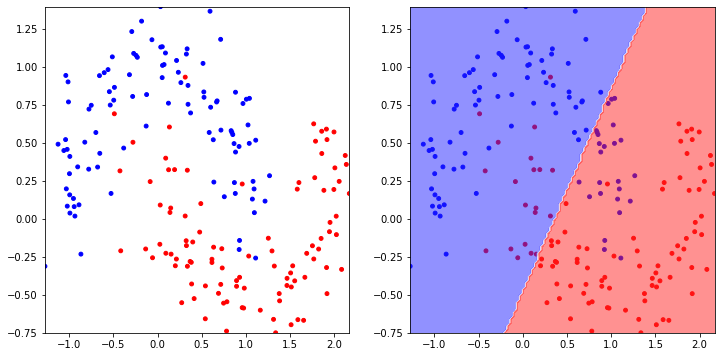

In [26]:
# mesmo problema, mas com regularização...

input_dim, output_dim = x.shape[1], y.shape[1]

# incializando a rede
nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-2)
nn.layers.append(Layer(input_dim=input_dim, output_dim=10, activation=tanh,reg_strength=0.1, reg_func=l2_regularization))
nn.layers.append(Layer(input_dim=10, output_dim=output_dim, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=1000)

# print(nn.layers[0].weights)
# print(nn.layers[0].biases)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

#obs a predição se aproximou de uma reta porque a regularização é alta

### Espiral

(200, 2) (200, 1)


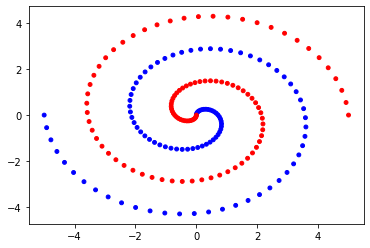

In [31]:
x, y = make_spiral(n_samples=100, n_class=2, radius=5, laps=1.75)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/5000. loss_train: 0.89774502
epoch: 1000/5000. loss_train: 0.07941388
epoch: 2000/5000. loss_train: 0.04051508
epoch: 3000/5000. loss_train: 0.02862583
epoch: 4000/5000. loss_train: 0.02302684
epoch: 5000/5000. loss_train: 0.01973850
Acurácia: 99.50%


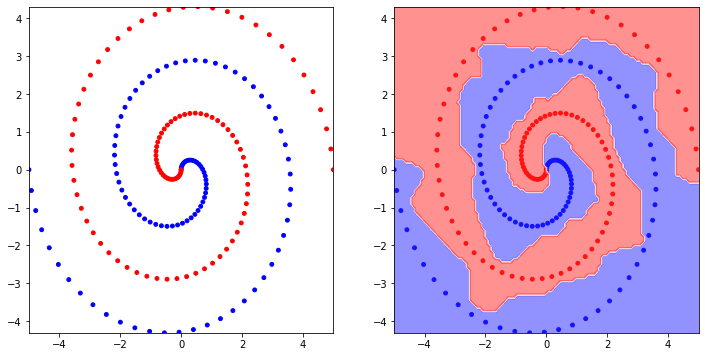

In [113]:
input_dim, output_dim = x.shape[1], y.shape[1]

# incializando a rede
nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=output_dim, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=1000)

# print(nn.layers[0].weights)
# print(nn.layers[0].biases)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

epoch:    0/5000. loss_train: 2.60932771 + 0.00000000 = 2.60932771. loss_val = 2.609328
epoch:  500/5000. loss_train: 0.71891030 + 0.00000000 = 0.71891030. loss_val = 0.718910
epoch: 1000/5000. loss_train: 0.33819169 + 0.00000000 = 0.33819169. loss_val = 0.338192
epoch: 1500/5000. loss_train: 0.10052789 + 0.00000000 = 0.10052789. loss_val = 0.100528
epoch: 2000/5000. loss_train: 0.07398165 + 0.00000000 = 0.07398165. loss_val = 0.073982
epoch: 2500/5000. loss_train: 0.05331446 + 0.00000000 = 0.05331446. loss_val = 0.053314


/tmp/ipykernel_55364/2662185116.py:4: RuntimeWarning: divide by zero encountered in log
  return - np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
/tmp/ipykernel_55364/2662185116.py:4: RuntimeWarning: invalid value encountered in multiply
  return - np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
/tmp/ipykernel_55364/2662185116.py:3: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


epoch: 3000/5000. loss_train: nan + nan = nan. loss_val =      nan
epoch: 3500/5000. loss_train: nan + nan = nan. loss_val =      nan
epoch: 4000/5000. loss_train: nan + nan = nan. loss_val =      nan
epoch: 4500/5000. loss_train: nan + nan = nan. loss_val =      nan
epoch: 5000/5000. loss_train: nan + nan = nan. loss_val =      nan
Acurácia: 50.00%


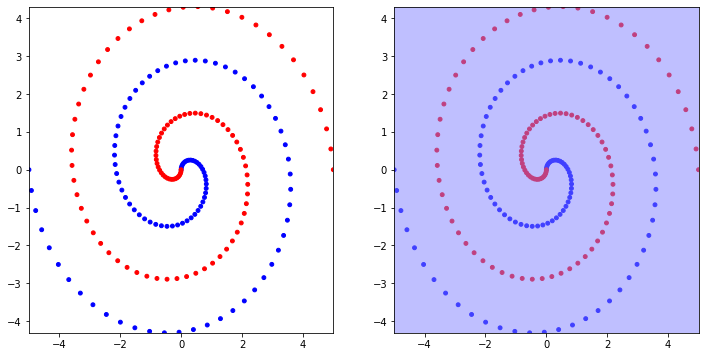

In [43]:
# batch normalization
input_dim, output_dim = x.shape[1], y.shape[1]

# incializando a rede
nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=10)
nn.layers.append(Layer(input_dim=input_dim, output_dim=20, activation=tanh, batch_norm=True))
nn.layers.append(Layer(input_dim=20, output_dim=output_dim, activation=sigmoid, batch_norm=True))

nn.fit(x, y, epochs=5000, verbose=500)

# print(nn.layers[0].weights)
# print(nn.layers[0].biases)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

## Classificação Multiclasse

### 3 Clusters Multiclasse

(300, 2) (300, 1)


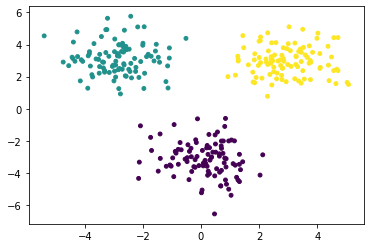

In [114]:
x, y = make_blobs(n_samples=300, n_features=2, centers=[(0, -3), (-3, 3), (3, 3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [115]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::60])

[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


epoch:    0/5000. loss_train: 1.82479800
epoch: 1000/5000. loss_train: 0.00130519
epoch: 2000/5000. loss_train: 0.00071428
epoch: 3000/5000. loss_train: 0.00050046
epoch: 4000/5000. loss_train: 0.00038809
epoch: 5000/5000. loss_train: 0.00031820
Acurácia: 100.00%


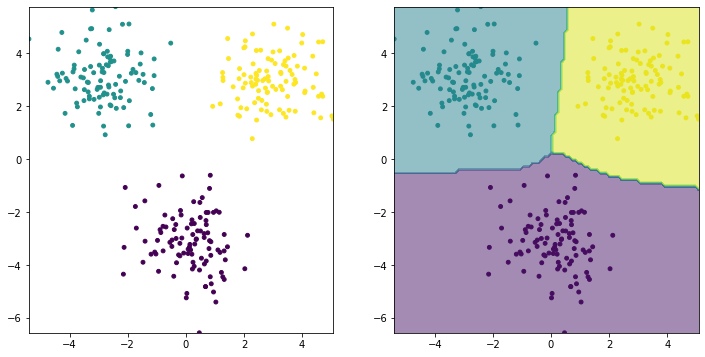

In [116]:
# DISCLAIMER: frameworks de deep learning usam o softmax como função de
#ativação na ultima camada e neg_log_likelihood como função de custo 

# exemplo do curso
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# incializando a rede
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=output_dim, activation=linear))

nn.fit(x, y_onehot, epochs=5000, verbose=1000)

# print(nn.layers[0].weights)
# print(nn.layers[0].biases)
    
y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### 4 Clusters Multiclasse

(400, 2) (400, 1)


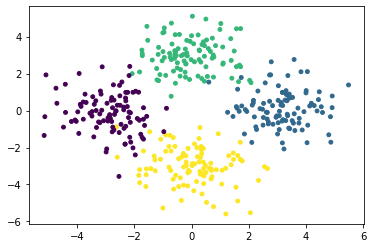

In [117]:
x, y = make_blobs(n_samples=400, n_features=2, centers=[(-3, 0), (3, 0), (0, 3), (0, -3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [118]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::70])

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]


epoch:    0/5000. loss_train: 2.64078906
epoch: 1000/5000. loss_train: 0.06526658
epoch: 2000/5000. loss_train: 0.06141458
epoch: 3000/5000. loss_train: 0.05923773
epoch: 4000/5000. loss_train: 0.05760490
epoch: 5000/5000. loss_train: 0.05623978
Acurácia: 97.50%


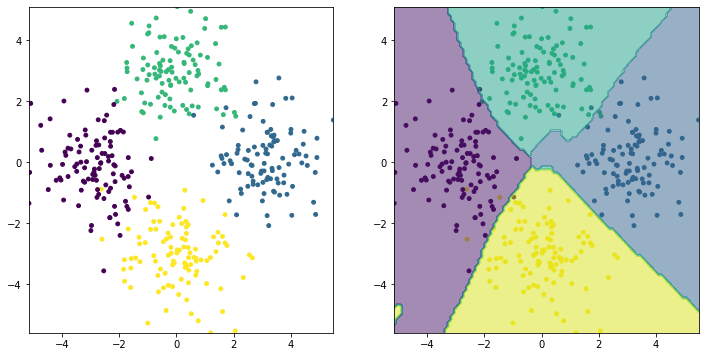

In [119]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# incializando a rede
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=output_dim, activation=linear))

nn.fit(x, y_onehot, epochs=5000, verbose=1000)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### Espiral - 5 Classes

(500, 2) (500, 1)


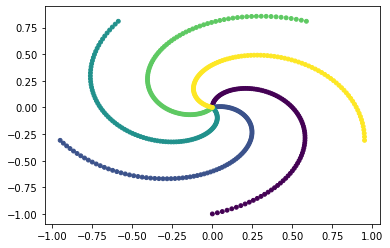

In [120]:
x, y = make_spiral(n_samples=100, n_class=5, radius=1, laps=0.5)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [121]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::100])

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


epoch:    0/5000. loss_train: 8.24557193
epoch: 1000/5000. loss_train: 0.11184209
epoch: 2000/5000. loss_train: 0.06792586
epoch: 3000/5000. loss_train: 0.05295189
epoch: 4000/5000. loss_train: 0.04499655
epoch: 5000/5000. loss_train: 0.03995766
Acurácia: 99.20%


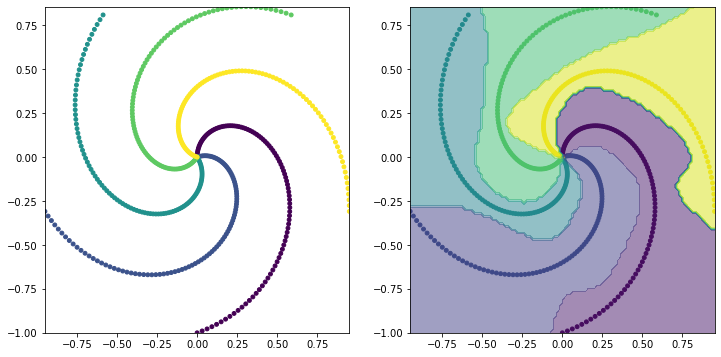

In [122]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# incializando a rede
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=20, activation=linear))
nn.layers.append(Layer(input_dim=20, output_dim=output_dim, activation=linear))
nn.fit(x, y_onehot, epochs=5000, verbose=1000)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### Make Classification - 4 Classes

(100, 2) (100, 1)


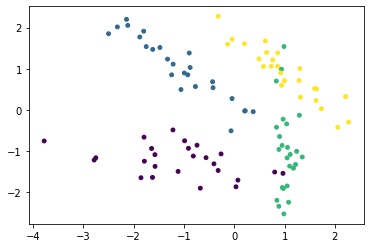

In [123]:
x, y = make_classification(n_samples=100, n_classes=4, n_features=2, n_clusters_per_class=1, n_redundant=0, n_repeated=0, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [124]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::10])

[[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]


epoch:    0/5000. loss_train: 5.86206479
epoch: 1000/5000. loss_train: 0.05604980
epoch: 2000/5000. loss_train: 0.04039571
epoch: 3000/5000. loss_train: 0.03047688
epoch: 4000/5000. loss_train: 0.02343200
epoch: 5000/5000. loss_train: 0.01991432
Acurácia: 99.00%


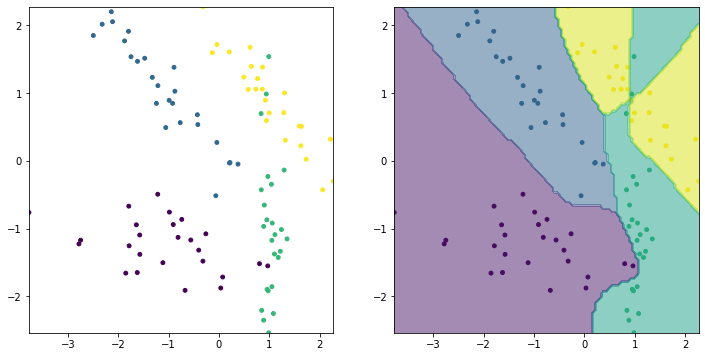

In [125]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# incializando a rede
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=20, activation=linear))
nn.layers.append(Layer(input_dim=20, output_dim=output_dim, activation=linear))
nn.fit(x, y_onehot, epochs=5000, verbose=1000)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### Iris Dataset

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
(150, 2) (150, 1)


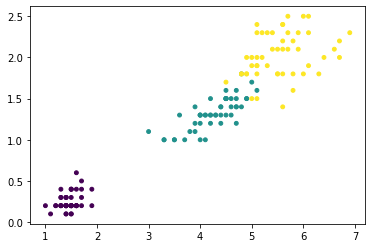

In [76]:
data = load_iris()
x, y = data.data[:, 2:], data.target.reshape(-1,1)

print(data.feature_names)
print(data.target_names)
print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [77]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::20])

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


epoch:    0/5000. loss_train: 2.49746111
epoch: 1000/5000. loss_train: 0.30558298
epoch: 2000/5000. loss_train: 0.23226019
epoch: 3000/5000. loss_train: 0.19674981
epoch: 4000/5000. loss_train: 0.17488385
epoch: 5000/5000. loss_train: 0.15983325
Acurácia: 96.67%


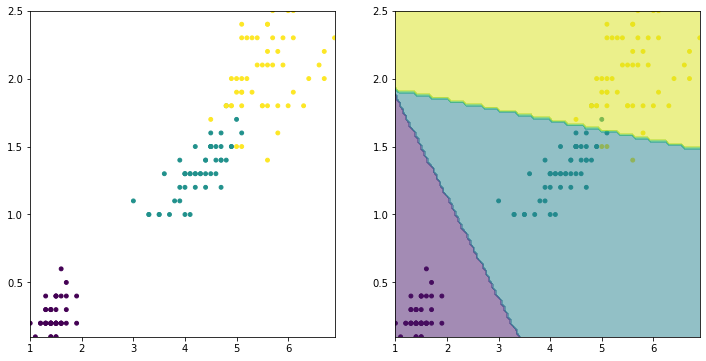

In [128]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# incializando a rede
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=output_dim, activation=linear))
nn.fit(x, y_onehot, epochs=5000, verbose=1000)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

epoch:    0/5000. loss_train: 1.20116297
epoch: 1000/5000. loss_train: 0.30104501
epoch: 2000/5000. loss_train: 0.23175443
epoch: 3000/5000. loss_train: 0.19688834
epoch: 4000/5000. loss_train: 0.17518672
epoch: 5000/5000. loss_train: 0.16018327
Acurácia: 96.67%


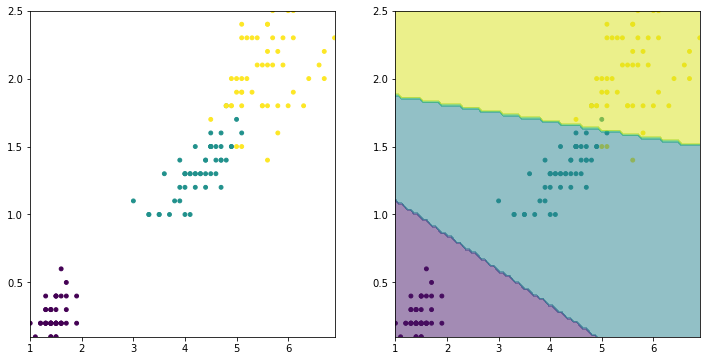

In [72]:
# utilizando batch
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# incializando a rede
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=output_dim, activation=linear))
nn.fit(x, y_onehot, epochs=5000, verbose=1000, batch_gen=batch_shuffle, batch_size=15)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

epoch:    0/5000. loss_train: 1.35026286
epoch: 1000/5000. loss_train: 0.67771458
epoch: 2000/5000. loss_train: 0.67771438
epoch: 3000/5000. loss_train: 0.67771438
epoch: 4000/5000. loss_train: 0.67771438
epoch: 5000/5000. loss_train: 0.67771438
Acurácia: 73.33%


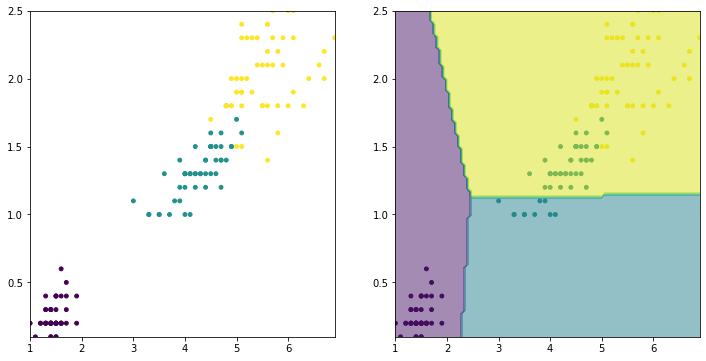

In [86]:
# learning rate decay
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# incializando a rede
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1, lr_decay_method=staircase_decay, lr_decay_rate=0.5, lr_decay_steps=50)
nn.layers.append(Layer(input_dim=input_dim, output_dim=output_dim, activation=linear))
nn.fit(x, y_onehot, epochs=5000, verbose=1000)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

# [Link para o Questionário](https://docs.google.com/forms/d/e/1FAIpQLSf1B3JKsPPPc1oYD_3FyX4UvNLpcXnTW2I177A_WE0_B56Elw/viewform?usp=sf_link)

# Referências

- [Tensorflow Playground](http://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.94880&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

- [Linear Classification](http://cs231n.github.io/linear-classify/)

__Regularization__:
- [Implementing Neural Network L1 Regularization](https://jamesmccaffrey.wordpress.com/2017/06/27/implementing-neural-network-l1-regularization/)
- [Implementing Neural Network L2 Regularization](https://jamesmccaffrey.wordpress.com/2017/06/29/implementing-neural-network-l2-regularization/)
- [Neural Network L2 Regularization Using Python](https://visualstudiomagazine.com/articles/2017/09/01/neural-network-l2.aspx)

__Momentum__:
- [Neural Network Momentum Using Python](https://visualstudiomagazine.com/articles/2017/08/01/neural-network-momentum.aspx)
- [Beyond SGD: Gradient Descent with Momentum and Adaptive Learning Rate](https://wiseodd.github.io/techblog/2016/06/22/nn-optimization/)

__Learning Rate Decay__:
- [Using Learning Rate Schedules for Deep Learning Models in Python with Keras](https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/)
- [Learning Rate Schedules and Adaptive Learning Rate Methods for Deep Learning](https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1)
- [Tensorflow Exponential Decay Documentation](https://www.tensorflow.org/api_docs/python/tf/train/exponential_decay)

__Batch Normalization__:
- [Understanding the backward pass through Batch Normalization Layer](https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html)
- [Deriving the Gradient for the Backward Pass of Batch Normalization](https://kevinzakka.github.io/2016/09/14/batch_normalization/)
- [Implementing BatchNorm in Neural Net](https://wiseodd.github.io/techblog/2016/07/04/batchnorm/)
- [What does the gradient flowing through batch normalization looks like ?](http://cthorey.github.io./backpropagation/)
- [GRADIENTS, BATCH NORMALIZATION AND LAYER NORMALIZATION](https://theneuralperspective.com/2016/10/27/gradient-topics/)

__Gradient Checking__:
- [cs231n](https://github.com/cs231n/cs231n.github.io/blob/master/neural-networks-3.md#gradcheck)
- [Gradient checking and advanced optimization](http://ufldl.stanford.edu/wiki/index.php/Gradient_checking_and_advanced_optimization)
- [BatchNormalization fails gradient checking](https://github.com/torch/nn/issues/744)